# Make some paper figs

In [1]:
import numpy as np
from pathlib import Path
import os
import re
import h5py
import pandas as pd
import logging
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

from graspy.plot import pairplot, heatmap
from lol import LOL
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr, ttest_rel, ttest_ind
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances

from nilearn import datasets, plotting
import nibabel as nib
import matplotlib as mpl

import sys; sys.path.append('../')
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
datadir = Path('/mnt/ssd3/ronan/data')
tag = '_min_rank-ZG3'#'_max_rank-ZG2' 
gccadir = datadir / f'gcca_05-26-10:39{tag}'#f'gcca_05-17-18:27{tag}' # 
external_dir = Path('../data/external')

save_dir = Path('../reports/pairwise_differences_8-14/')
heatmap_dir = Path('../reports/heatmaps_8-14/')
SOURCE = 'gcca'

In [3]:
## Gradients
gradients = [
    (0), (1), (2),
    #(0,1), (1,2), (2,0),
    #(0,1,2)
]

lookup = {'Experts All':[0,1,2],
          'Novices All':[3,4,5],
          'Experts Resting':[0],
          'Experts Open Monitoring':[1],
          'Experts Compassion':[2],
          'Novices Resting':[3],
          'Novices Open Monitoring':[4],
          'Novices Compassion':[5],
          'Experts Meditating':[1,2],
          'Novices Meditating':[4,5],
          'Resting':[0,3],
          'Compassion':[2,5],
          'Open Monitoring':[1,4],
          'Meditating':[1,2,4,5]
}
test_list = []
# ## Intra (within) Trait, Inter (between) State
test_list += [
    # Permutation: restricted, within subject
    ('Experts Resting', 'Experts Compassion', 'within'),
    ('Experts Resting', 'Experts Open Monitoring', 'within'),
    ('Experts Open Monitoring', 'Experts Compassion', 'within'),
    # ('Experts Resting', 'Experts Meditating', 'within'),
    ('Novices Resting', 'Novices Compassion', 'within'),
    ('Novices Resting', 'Novices Open Monitoring', 'within'),
    ('Novices Open Monitoring', 'Novices Compassion', 'within'),
    # ('Novices Resting', 'Novices Meditating', 'within')
]
# ## Inter (between) Trait, Intra (within) State
test_list += [
    # Permutation: full
    ('Experts Resting', 'Novices Resting', 'full'),
    ('Experts Compassion', 'Novices Compassion', 'full'),
    ('Experts Open Monitoring', 'Novices Open Monitoring', 'full'),
]
# Permutation: restricted, across subject
test_list += [
    ('Experts Meditating', 'Novices Meditating', 'across'),
    ('Experts All', 'Novices All', 'across'),
]
## Inter (between) Trait, Inter (between) State
test_list += [
    # Permutation: free
    ('Experts Resting', 'Novices Compassion', 'full'),
    ('Experts Resting', 'Novices Open Monitoring', 'full'),
    ('Experts Compassion', 'Novices Resting', 'full'),
    ('Experts Compassion', 'Novices Open Monitoring', 'full'),
    ('Experts Open Monitoring', 'Novices Resting', 'full'),
    ('Experts Open Monitoring', 'Novices Compassion', 'full'),
    # Permutation: restricted, permute state (preserve # labels)
    # # ('Experts Resting', 'Novices Meditating', 'across'),
    # # ('Experts Meditating', 'Novices Resting', 'across'),
]
# # Intra State (need to figure out these permutations)
test_list += [
    # Permutation: restricted, permute state
    ('Resting', 'Compassion', 'within'),
    ('Resting', 'Open Monitoring', 'within'),
    ('Open Monitoring', 'Compassion', 'within'),
    # Permutation: restricted, permute state (preserve # labels)
    # ('Resting', 'Meditating', 'within')
]

SIGNIFICANT_TESTS = [5,17,19]
SIGNIFICANT_GRADIENTS = [
    [[0,1]],
    [[2]],
    [[1,2]]
]

In [4]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()

In [5]:
def visualize_embeddings(
    embeddings,
    save_path=False,
    vmax=None,
    symmetric_cbar=True,
    colorbar=False,
    n_embed = 1,
    title = None,
):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(n_embed, 4, subplot_kw={'projection': '3d'}, figsize=(res_scale*5, res_scale*n_embed))
    if n_embed==1:
        axes = [axes]
    
    plt.subplots_adjust(wspace=0, hspace=0)        

    for i,ax in enumerate(axes):
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(external_dir / 'lh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[:len(cortex_left)]

        plotting.plot_surf_stat_map(fsa5.infl_left, 
          conn_map, hemi='left', colorbar=False, cmap='RdBu_r', axes = ax[0],
          vmax=vmax, symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_left,
          conn_map, hemi='left', colorbar=False, cmap='RdBu_r', view='medial', axes=ax[1], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

        cortex_right = nib.freesurfer.read_label(external_dir / 'rh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left):]

        plotting.plot_surf_stat_map(fsa5.infl_right, 
          conn_map, hemi='right', colorbar=False, cmap='RdBu_r', axes = ax[2], 
           vmax=vmax,symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_right,
          conn_map, hemi='right', colorbar=colorbar, cmap='RdBu_r', view='medial', axes=ax[3], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

    if title:
        fig.suptitle(title, fontsize=20, y=0.92)
    if save_path:
        plt.savefig(f'{str(save_path)}.png', format='png', bbox_inches='tight')
    else:
        return fig
#         plt.show()
#         plt.close(fig)
    
def make_cbar(vmax, save_path = None, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.RdBu_r
    else:
        cmap = mpl.cm.Blues_R
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    #cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    
    #cb1.set_clim(vmin, vmax)
    #cb1.set_label('Some Units')
    if save_path:
        plt.savefig(f'{str(save_path)}.pdf', bbox_inches='tight')
    plt.close(fig)

### Raw viz

In [25]:
# script code
if SOURCE == "gcca":
    flag = "_gcca"
    ftype = "h5"
    source_dir = gccadir
elif SOURCE == "dmap":
    flag = "_emb"
    ftype = "npy"
    source_dir = dmap_dir
else:
    raise ValueError(f"{SOURCE} invalid data key")
groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, source=SOURCE
)

In [27]:
SAVE = False
COLORBAR = True
n_embed = 3

In [35]:
label_transform = {
    "e": "Expert",
    "n": "Novice",
    "compassion": "Compasson",
    "restingstate": "Resting",
    "openmonitoring": "Open",
}
names = [f"{label_transform[a]} {label_transform[b]}" for a, b in labels]

<Figure size 432x288 with 0 Axes>

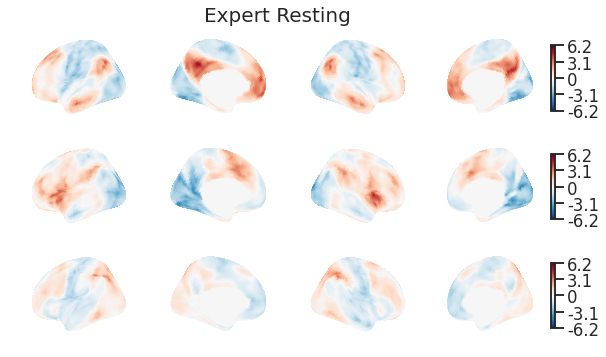

<Figure size 432x288 with 0 Axes>

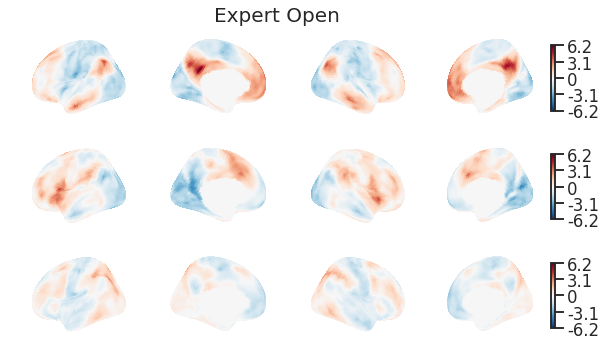

<Figure size 432x288 with 0 Axes>

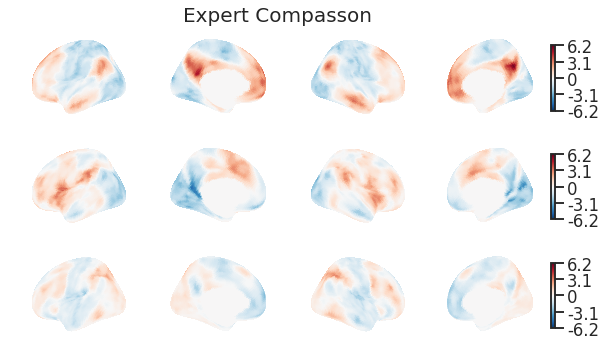

<Figure size 432x288 with 0 Axes>

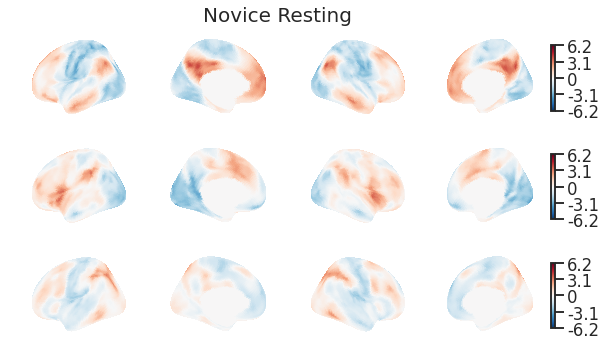

<Figure size 432x288 with 0 Axes>

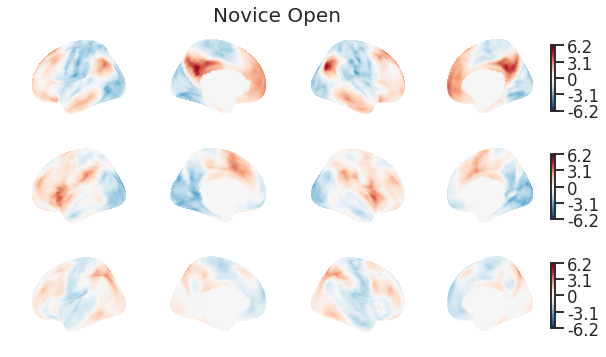

<Figure size 432x288 with 0 Axes>

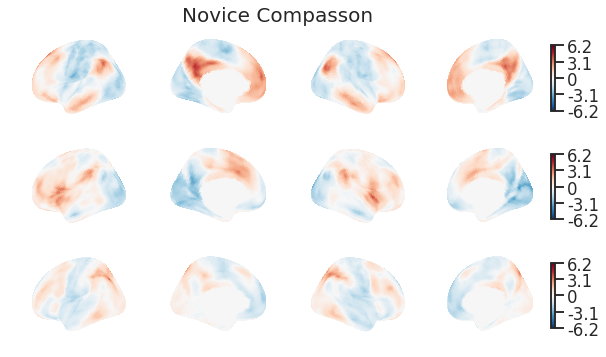

In [37]:
means = []
for group in groups:
    ## Select Gradient(s)
    X = np.stack(group)
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    mu = X.mean(axis=0)
    std = X.std(axis=0, ddof=1)
    means.append((mu / std)[:, :n_embed])

if COLORBAR:
    vmax = np.max(np.abs(means))

for mean, name in zip(means, names):
    if SAVE:
        title = False
    else:
        title = f"{name}"
    visualize_embeddings(
        mean,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=n_embed,
        vmax=vmax,
        title=title,
    )
    if SAVE:
        plt.savefig(save_dir / f'{SOURCE}_{name}_{grads}_mean.pdf', bbox_inches='tight', pad_inches = 0)
        plt.show()
    else:
        plt.show()

if SAVE and not COLORBAR:
    make_cbar(vmax, save_dir / f'{SOURCE}_{name}_colorbar')

### Pairwise diff figures (welch t-stats) for all gradients

In [6]:
groups, labels, subjs = get_latents(gccadir, flag="_gcca", ids=True)

In [7]:
SAVE = False
COLORBAR = True

<Figure size 432x288 with 0 Axes>

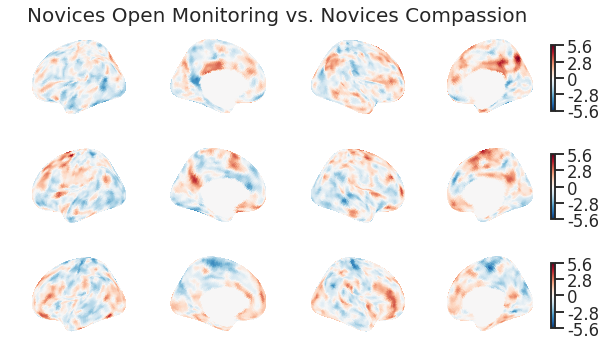

<Figure size 432x288 with 0 Axes>

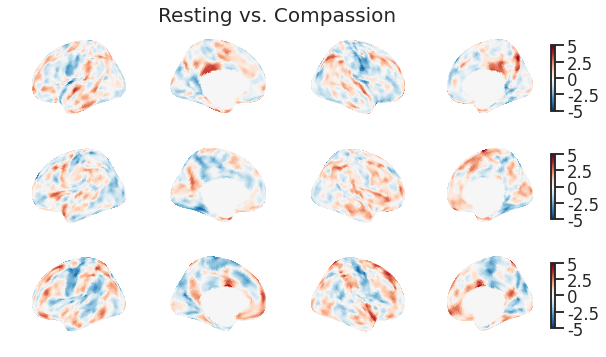

<Figure size 432x288 with 0 Axes>

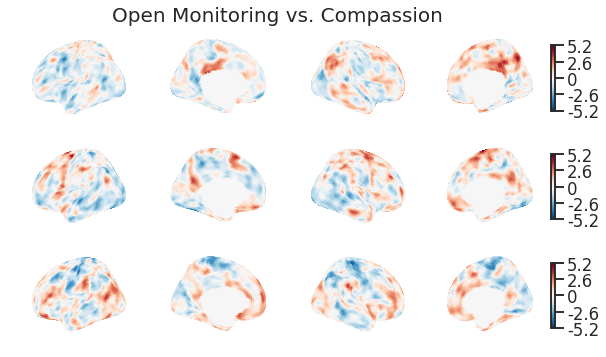

In [64]:
for sig_grads, (g1,g2,permute_structure) in zip(SIGNIFICANT_GRADIENTS, np.asarray(test_list)[SIGNIFICANT_TESTS]):
    name = f'{g1} vs. {g2}'
    results_dict = {}
    
    g1_labels = lookup[g1]
    g2_labels = lookup[g2]

    X1 = np.vstack([np.asarray(groups[i]) for i in g1_labels])
    X2 = np.vstack([np.asarray(groups[i]) for i in g2_labels])
    
    subjs1 = np.concatenate([np.asarray(subjs[i]) for i in g1_labels])
    subjs2 = np.concatenate([np.asarray(subjs[i]) for i in g2_labels])
    if permute_structure == 'within':
        X1 = X1[np.argsort(subjs1)]
        X2 = X2[np.argsort(subjs2)]
    
    X1 /= np.linalg.norm(X1, axis=1, keepdims=True)
    X2 /= np.linalg.norm(X2, axis=1, keepdims=True)
    
    tstats = []
    for grads in gradients:#sig_grads:
        X1g = X1[:, :, grads].reshape(X1.shape[0], -1)
        X2g = X2[:, :, grads].reshape(X2.shape[0], -1)
        
        #tstats_mu = X1g.mean(axis=0) - X2g.mean(axis=0)
        #tstats_var = X1g.var(axis=0, ddof=1) / X1g.shape[0] + X2g.var(axis=0, ddof=1) / X2g.shape[0]
        #tstats.append(tstats_mu / np.sqrt(tstats_var))
        if permute_structure == 'within':
            tstats.append(ttest_rel(X1g, X2g, axis=0)[0])
        else:
            tstats.append(ttest_ind(X1g, X2g, axis=0, equal_var=False)[0])
        
    vmax = np.max(np.abs(np.concatenate(tstats)))
    
    # All 3 gradients
    if SAVE:
        title = False
    else:
        title = name
    visualize_embeddings(
        np.vstack(tstats).T,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=3,
        vmax=vmax,
        title=title,
    )

    if SAVE:
        plt.savefig(save_dir / f'{SOURCE}_{name}_{grads}_tstats.pdf', bbox_inches='tight', pad_inches = 0)
        plt.show()
    else:
        plt.show()
# gradients individually
#     for tstat, grads in zip(tstats, gradients):
#         print(f'{name}: Gradient {grads+1}')
#         if COLORBAR:
#             vmax = np.max(np.abs(tstat))
#         if SAVE:
#             title = False
#         else:
#             title = name
#         visualize_embeddings(
#             tstat[:,None],
#             save_path=False,
#             colorbar=COLORBAR,
#             n_embed=3,
#             vmax=vmax,
#             title=title,
#         )

#         if SAVE:
#             plt.savefig(save_dir / f'{SOURCE}_{name}_{grads}_tstats.pdf', bbox_inches='tight', pad_inches = 0)
#             plt.show()
#         else:
#             plt.show()
    
    if SAVE and not COLORBAR:
        make_cbar(vmax, save_dir / f'{name}_colorbar')

### Heatmaps

In [225]:
X = np.vstack(groups)
X = X.reshape(X.shape[0], -1)
X = X[np.argsort(np.concatenate(subjs)),:]
X_dists = pairwise_distances(X, metric="euclidean")

In [226]:
def center_distmat(distx):  # pragma: no cover
    """Centers the distance matrices"""
    n = distx.shape[0]
    exp_distx = (
        np.repeat((distx.sum(axis=0) / (n - 2)), n).reshape(-1, n).T
        + np.repeat((distx.sum(axis=1) / (n - 2)), n).reshape(-1, n)
        - distx.sum() / ((n - 1) * (n - 2))
    )
    cent_distx = distx - exp_distx
    np.fill_diagonal(cent_distx, 0)
    return cent_distx

In [227]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def _unique_like(vals):
    # gives output like
    uniques, inds, counts = np.unique(vals, return_index=True, return_counts=True)
    inds_sort = np.argsort(inds)
    uniques = uniques[inds_sort]
    counts = counts[inds_sort]
    return uniques, counts

def _get_freqs(inner_labels, outer_labels=None):
    # use this because unique would give alphabetical
    _, outer_freq = _unique_like(outer_labels)
    outer_freq_cumsum = np.hstack((0, outer_freq.cumsum()))

    # for each group of outer labels, calculate the boundaries of the inner labels
    inner_freq = np.array([])
    for i in range(outer_freq.size):
        start_ind = outer_freq_cumsum[i]
        stop_ind = outer_freq_cumsum[i + 1]
        _, temp_freq = _unique_like(inner_labels[start_ind:stop_ind])
        inner_freq = np.hstack([inner_freq, temp_freq])
    inner_freq_cumsum = np.hstack((0, inner_freq.cumsum()))

    return inner_freq, inner_freq_cumsum, outer_freq, outer_freq_cumsum
# assume that the graph has already been plotted in sorted form
def _plot_groups(ax, graph, inner_hier_labels, outer_labels=None, fontsize=30, brackets=False):
    inner_labels = np.array(inner_hier_labels)
    plot_outer = True
    if outer_labels is None:
        outer_labels = np.ones_like(inner_labels)
        plot_outer = False

#     sorted_inds = _sort_inds(graph, inner_labels, outer_labels, False)
#     inner_labels = inner_labels[sorted_inds]
#     outer_labels = outer_labels[sorted_inds]

    inner_freq, inner_freq_cumsum, outer_freq, outer_freq_cumsum = _get_freqs(
        inner_labels, outer_labels
    )
    inner_unique, _ = _unique_like(inner_labels)
    outer_unique, _ = _unique_like(outer_labels)

    n_verts = graph.shape[0]
    axline_kws = dict(linestyle="-", lw=0.9, alpha=0.5, zorder=3, color="grey")
    # draw lines
    for x in inner_freq_cumsum[1:-1]:
        ax.vlines(x, 0, n_verts + 1, **axline_kws)
        ax.hlines(x, 0, n_verts + 1, **axline_kws)

    # add specific lines for the borders of the plot
    pad = 0.001
    low = pad
    high = 1 - pad
    ax.plot((low, low), (low, high), transform=ax.transAxes, **axline_kws)
    ax.plot((low, high), (low, low), transform=ax.transAxes, **axline_kws)
    ax.plot((high, high), (low, high), transform=ax.transAxes, **axline_kws)
    ax.plot((low, high), (high, high), transform=ax.transAxes, **axline_kws)
    
    if brackets:
        # generic curve that we will use for everything
        lx = np.linspace(-np.pi / 2.0 + 0.05, np.pi / 2.0 - 0.05, 500)
        tan = np.tan(lx)
        curve = np.hstack((tan[::-1], tan))

        divider = make_axes_locatable(ax)

        # inner curve generation
        inner_tick_loc = inner_freq.cumsum() - inner_freq / 2
        inner_tick_width = inner_freq / 2
        # outer curve generation
        outer_tick_loc = outer_freq.cumsum() - outer_freq / 2
        outer_tick_width = outer_freq / 2

        # top inner curves
        ax_x = divider.new_vertical(size="5%", pad=0.0, pack_start=False)
        ax.figure.add_axes(ax_x)
        _plot_brackets(
            ax_x,
            np.tile(inner_unique, len(outer_unique)),
            inner_tick_loc,
            inner_tick_width,
            curve,
            "inner",
            "x",
            n_verts,
            fontsize,
        )
        # side inner curves
        ax_y = divider.new_horizontal(size="5%", pad=0.0, pack_start=True)
        print(inner_unique)
        ax.figure.add_axes(ax_y)
        _plot_brackets(
            ax_y,
            np.tile(["\n".join(iu.split(" ")) for iu in inner_unique], len(outer_unique)),
            inner_tick_loc,
            inner_tick_width,
            curve,
            "inner",
            "y",
            n_verts,
            fontsize,
        )
    
    return ax

def _plot_brackets(
    ax, group_names, tick_loc, tick_width, curve, level, axis, max_size, fontsize
):
    for x0, width in zip(tick_loc, tick_width):
        x = np.linspace(x0 - width, x0 + width, 1000)
        if axis == "x":
            ax.plot(x, -curve, c="k")
            ax.patch.set_alpha(0)
        elif axis == "y":
            ax.plot(curve, x, c="k")
            ax.patch.set_alpha(0)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.tick_params(axis=axis, which=u"both", length=0, pad=7)
    for direction in ["left", "right", "bottom", "top"]:
        ax.spines[direction].set_visible(False)
    if axis == "x":
        ax.set_xticks(tick_loc)
        ax.set_xticklabels(group_names, fontsize=fontsize, verticalalignment="center")
        ax.xaxis.set_label_position("top")
        ax.xaxis.tick_top()
        ax.xaxis.labelpad = 30
        ax.set_xlim(0, max_size)
        ax.tick_params(axis="x", which="major", pad=5 + fontsize / 4)
    elif axis == "y":
        ax.set_yticks(tick_loc)
        ax.set_yticklabels(group_names, fontsize=fontsize, verticalalignment="center")
        ax.set_ylim(0, max_size)
        ax.invert_yaxis()

#### All subjects

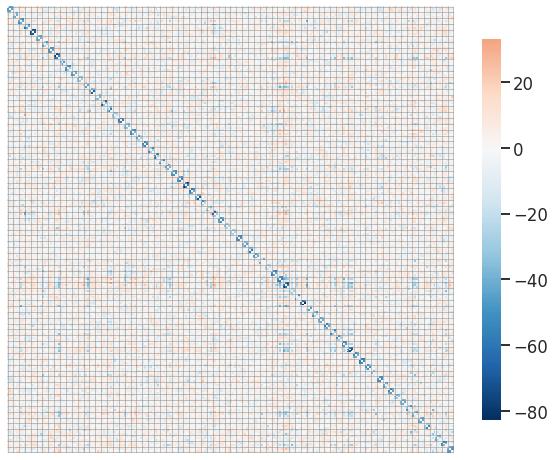

In [229]:
fig = heatmap(
    center_distmat(X_dists),
    #title=f"Subject scans distance matrix (centered)",
    transform=None,
    #inner_hier_labels=np.concatenate([[i+1]*3 for i in range(int(X_dists.shape[0]/3))]),#np.sort(np.concatenate(subjs)),
    #hier_label_fontsize=0,
)
ax = _plot_groups(
    fig,
    center_distmat(X_dists),
    np.concatenate([[i+1]*3 for i in range(int(X_dists.shape[0]/3))]),
)
plt.savefig(heatmap_dir / f'doubly_centered_l2_subj_distmat.pdf', bbox_inches='tight')
plt.show()

#### Significant tests

In [74]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
label_transform = {
    "e": "E.",
    "n": "N.",
    "compassion": "Compasson",
    "restingstate": "Resting",
    "openmonitoring": "Open",
}
y_labels = [f"{label_transform[a]} {label_transform[b]}" if for a, b in y]

In [117]:
name_switch = {
    'Experts All':'E All',
    'Novices All':'N All',
    'Experts Resting':'E Resting.',
    'Experts Open Monitoring':'E Open M.',
    'Experts Compassion':'E Compassion.',
    'Novices Resting':'N Resting',
    'Novices Open Monitoring':'N Open M.',
    'Novices Compassion':'N Compassion',
    'Experts Meditating':'E Med.',
    'Novices Meditating':'N Med.',
    'Resting':'Resting',
    'Compassion':'Compassion',
    'Open Monitoring':'Open Monitoring',
    'Meditating':'Med.',
}

gradients = [
    (0), (1), (2),
    (0,1), (1,2), (2,0),
    (0,1,2)
]

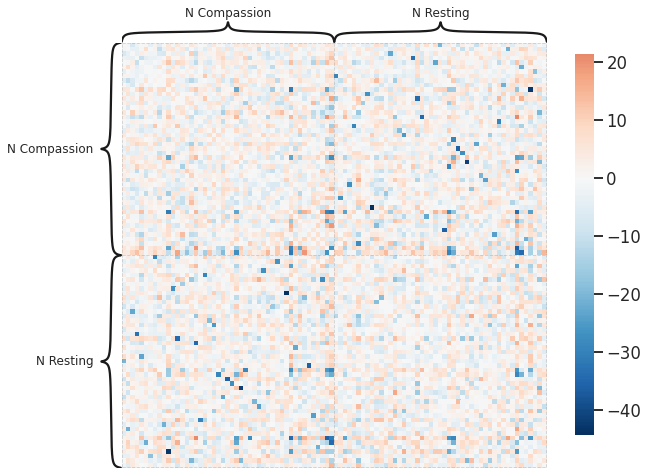

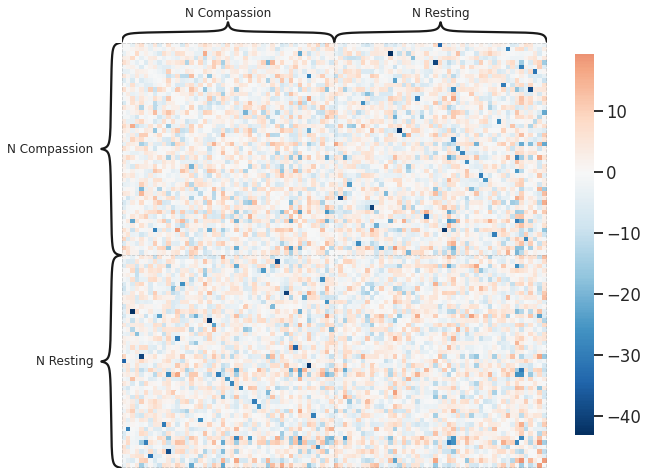

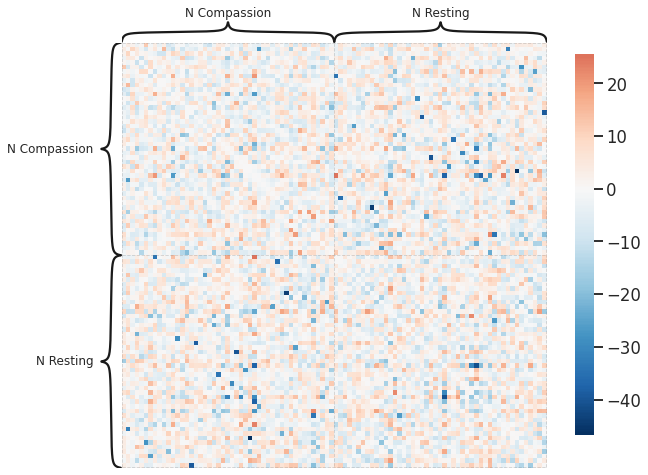

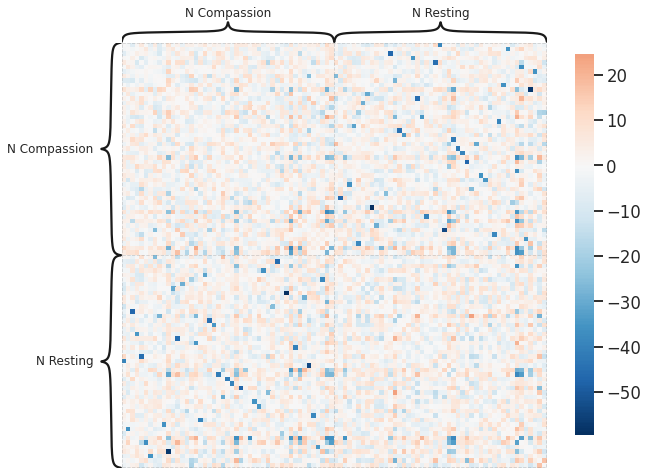

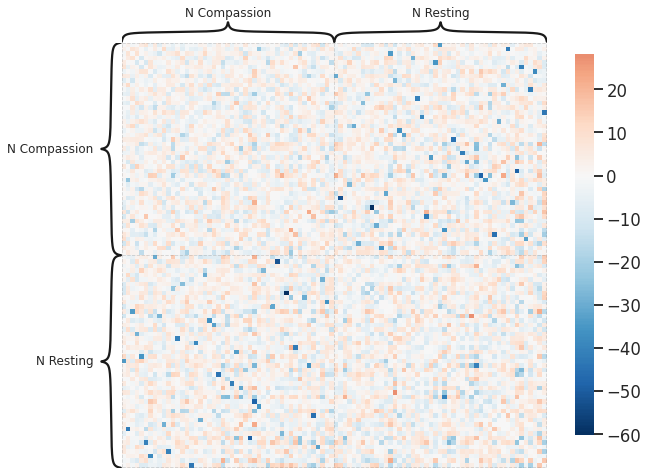

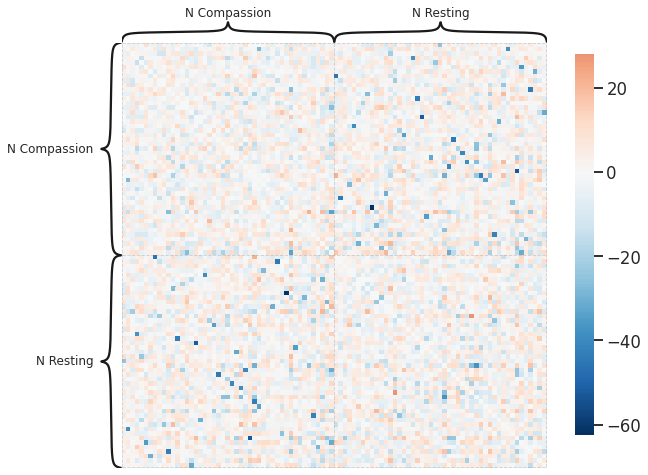

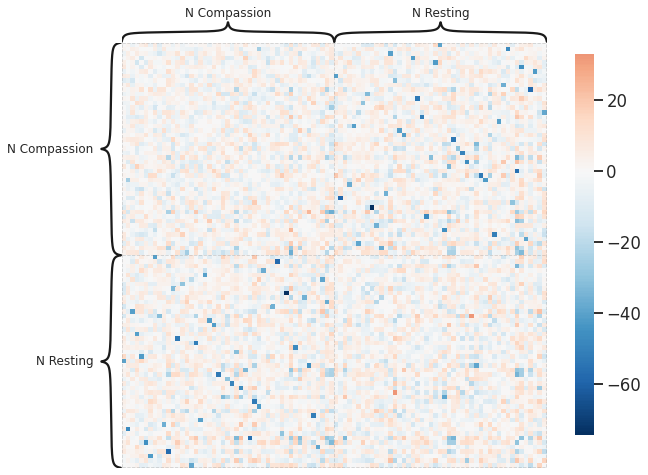

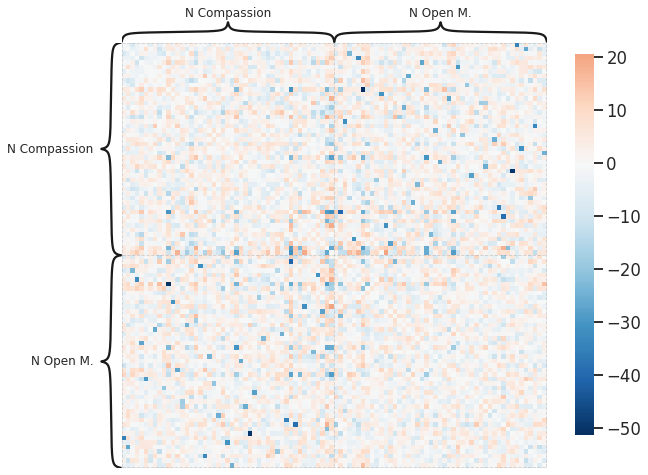

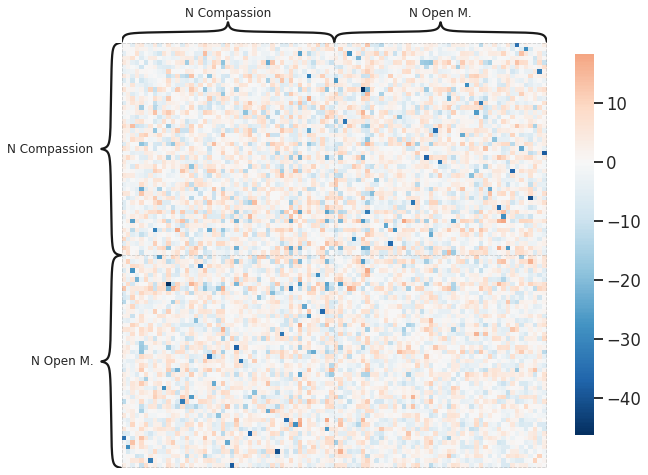

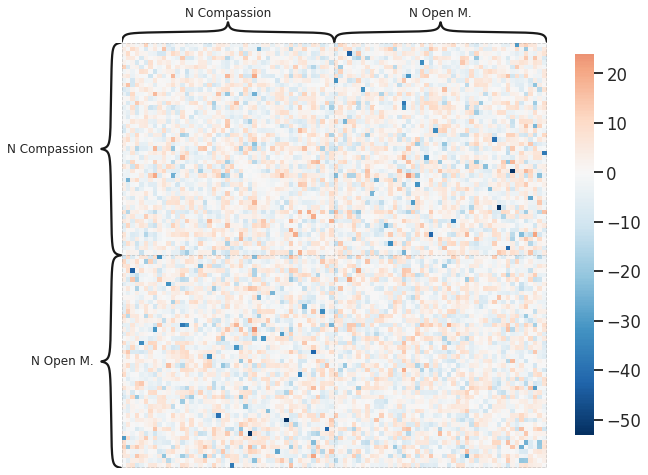

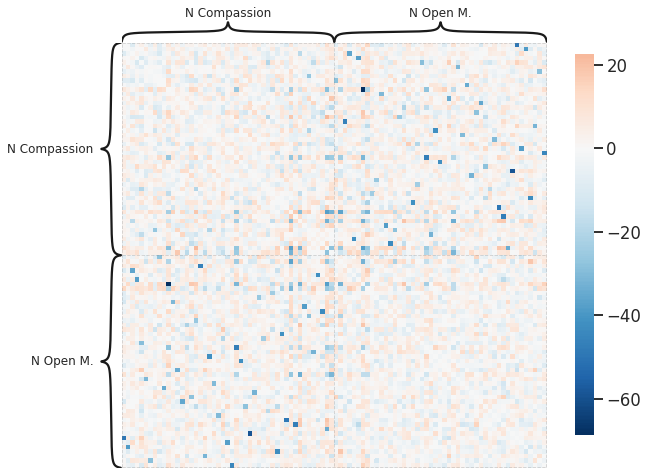

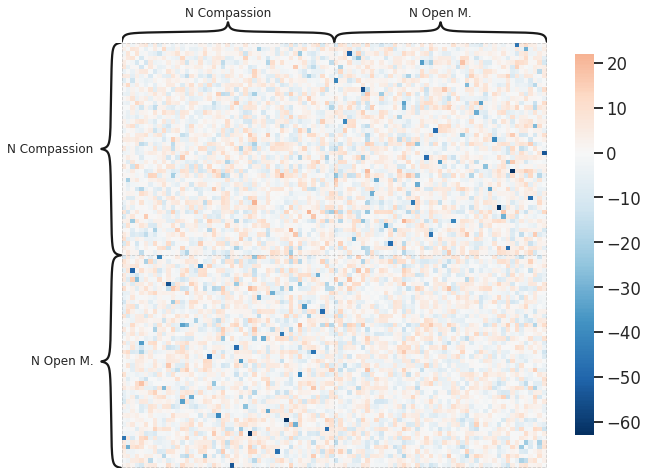

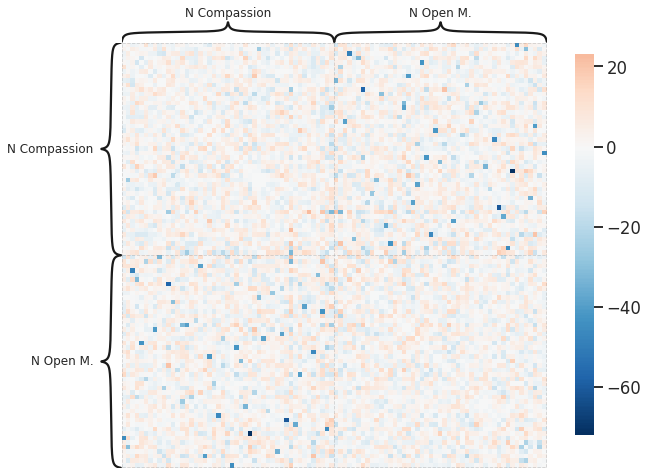

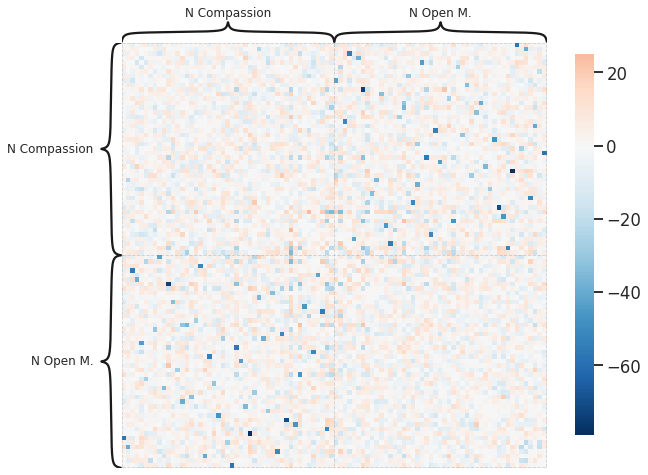

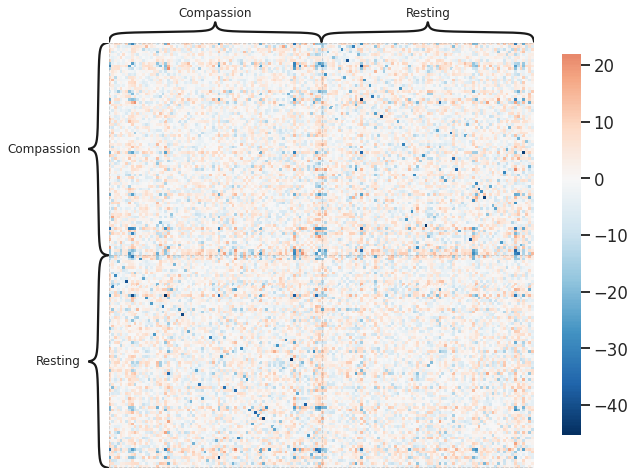

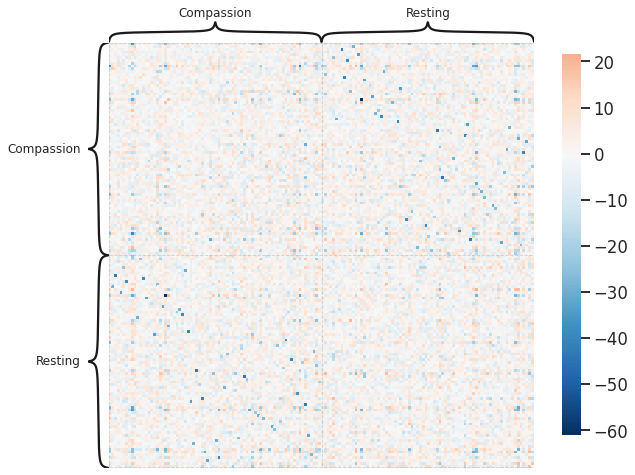

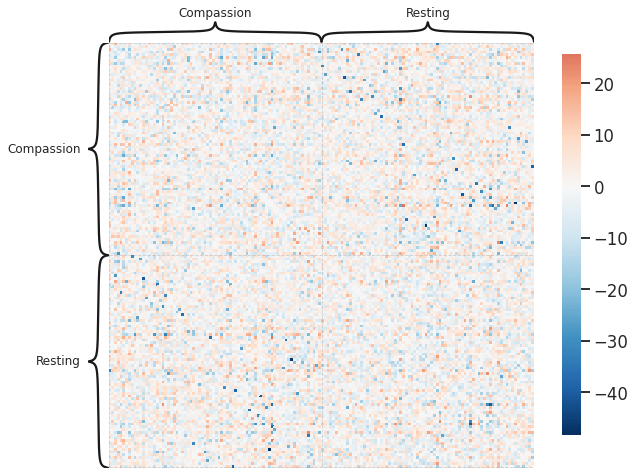

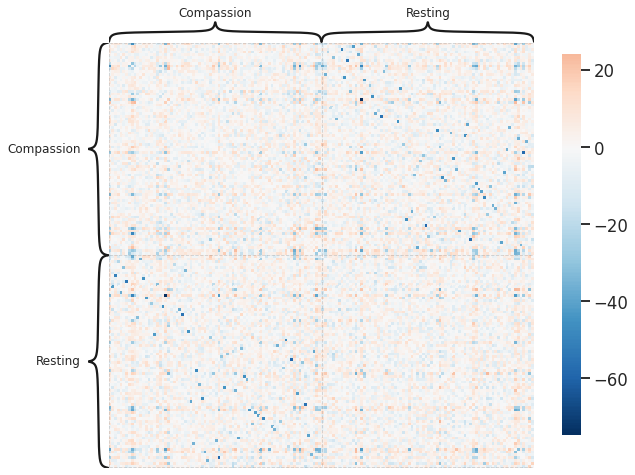

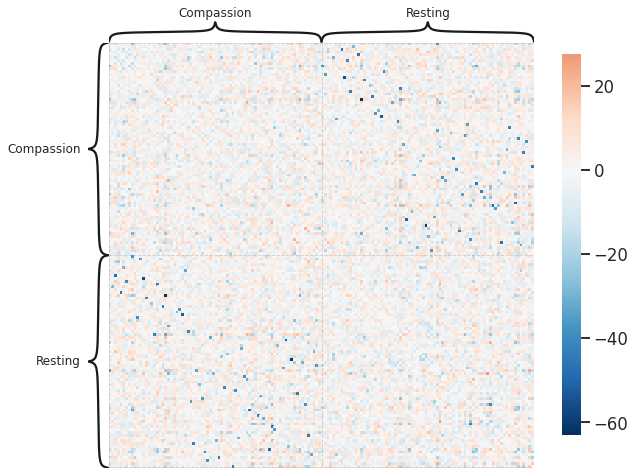

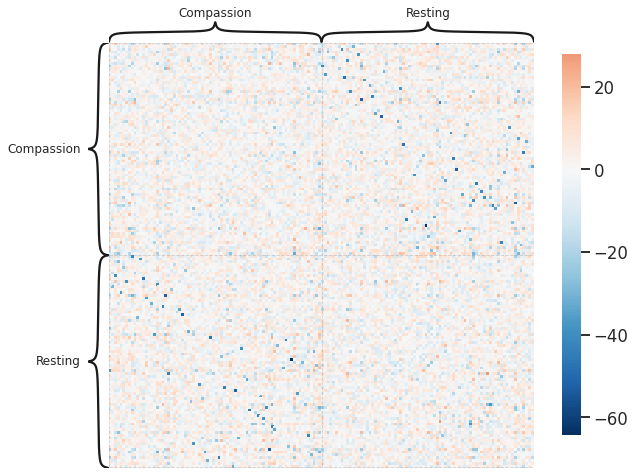

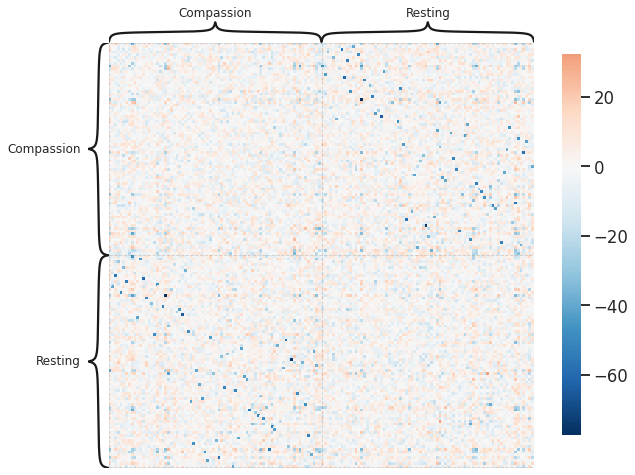

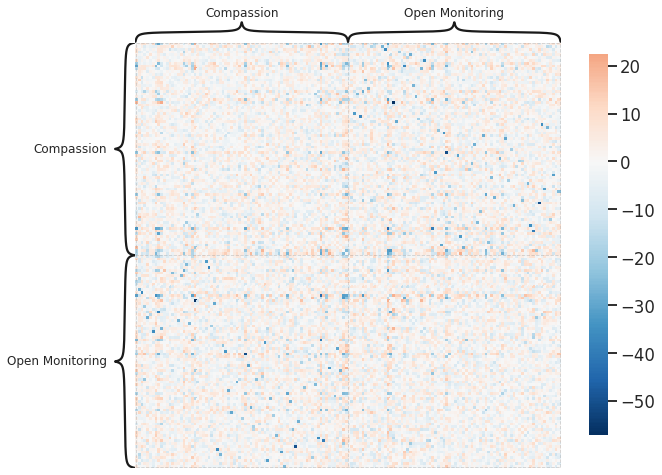

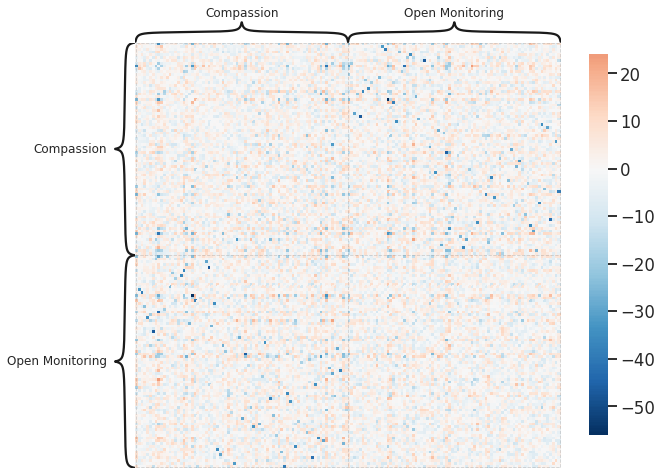

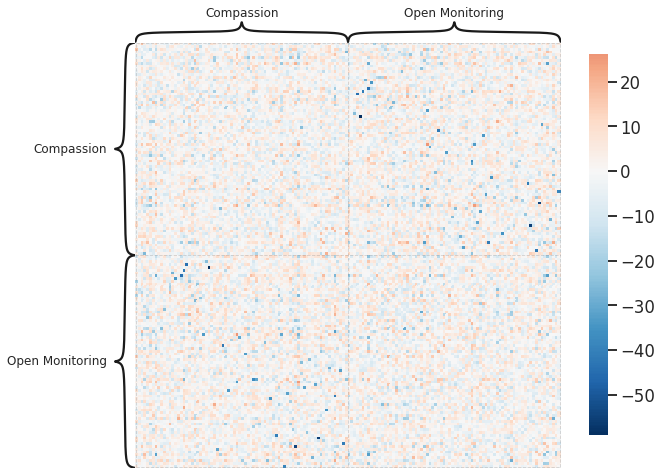

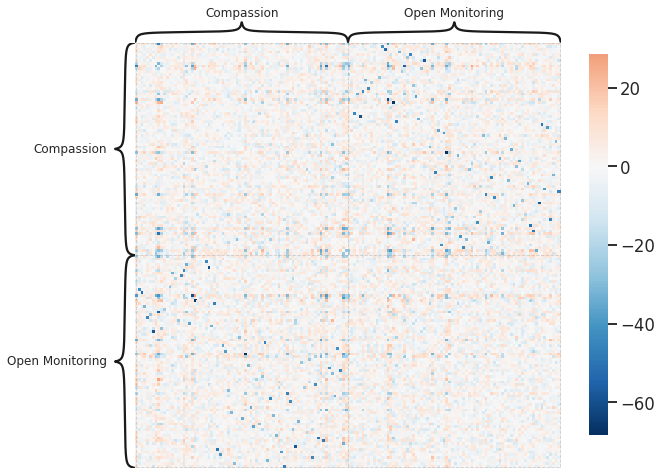

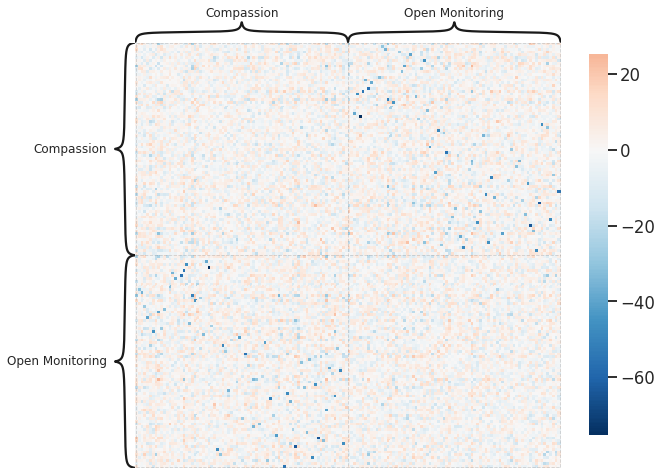

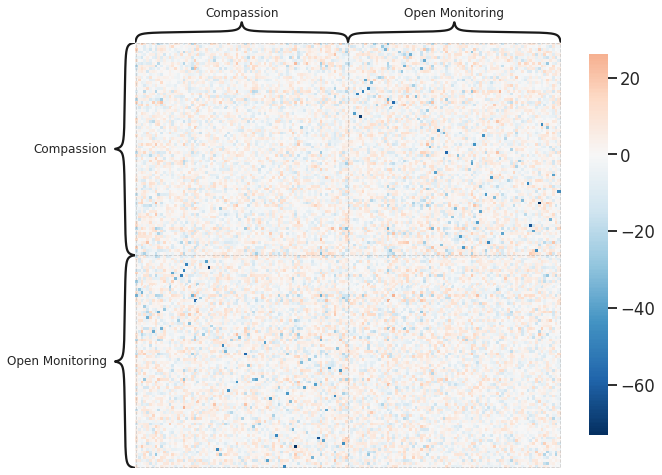

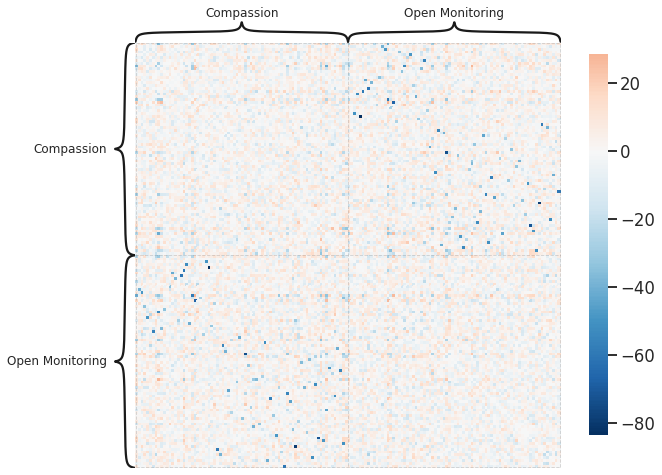

In [119]:
for (g1,g2,permute_structure) in np.asarray(test_list)[SIGNIFICANT_TESTS]:
    name = f'{g1} vs. {g2}'
    results_dict = {}
    
    g1_labels = lookup[g1]
    g2_labels = lookup[g2]

    X1 = np.vstack([np.asarray(groups[i]) for i in g1_labels])
    X2 = np.vstack([np.asarray(groups[i]) for i in g2_labels])
    
    tstats = []
    for grads in gradients:
        X1g = X1[:, :, grads].reshape(X1.shape[0], -1)
        X2g = X2[:, :, grads].reshape(X2.shape[0], -1)
        
        X = np.vstack(np.vstack((X1g, X2g)))
        X = X.reshape(X.shape[0], -1)
        X_dists = pairwise_distances(X, metric="euclidean")
        
        fig = heatmap(
            center_distmat(X_dists),
            #title=f"{name} {grads}",
            transform=None,
            inner_hier_labels = [name_switch[g1]]*X1.shape[0] + [name_switch[g2]]*X2.shape[0],
            #inner_hier_labels = ["\n".join(g1.split(" "))]*X1.shape[0] + ["\n".join(g2.split(" "))]*X2.shape[0],
            hier_label_fontsize=12,
        )

        plt.savefig(heatmap_dir / f'{name}_{grads}_centered_distmat.pdf', bbox_inches='tight')
        plt.show()

## Pvalues heatmap

In [6]:
name_dict = {
    'Gradients 0':'Gradient 1',
    'Gradients 1':'Gradient 2',
    'Gradients 2':'Gradient 3',
    'Gradients (0, 1)':'Gradients 1,2',
    'Gradients (1, 2)':'Gradients 2,3',
    'Gradients (2, 0)':'Gradients 1,3',
    'Gradients (0, 1, 2)':'Gradients 1,2,3',
    'Gradients 0':'Gradient 1',
    'Gradients 1':'Gradient 2',
    'Gradients 2':'Gradient 3',
    'Gradients (0, 1)':'Gradients 1,2',
    'Gradients (1, 2)':'Gradients 2,3',
    'Gradients (2, 0)':'Gradients 1,3',
    'Gradients (0, 1, 2)':'Gradients 1,2,3',
    'Experts Resting vs. Experts Compassion':['EXP','res', 'EXP','com'],
    'Experts Resting vs. Experts Open Monitoring':['EXP','res', 'EXP','o m'],
    'Experts Open Monitoring vs. Experts Compassion':['EXP','o m', 'EXP','com'],
    'Experts Resting vs. Experts Meditating':['EXP','res', 'EXP','med'],
    'Novices Resting vs. Novices Compassion':['NOV','res', 'NOV','com'],
    'Novices Resting vs. Novices Open Monitoring':['NOV','res', 'NOV','o m'],
    'Novices Open Monitoring vs. Novices Compassion':['NOV','o m', 'NOV','com'],
    'Novices Resting vs. Novices Meditating':['NOV','res', 'NOV','med'],
    'Experts Resting vs. Novices Resting':['EXP','res', 'NOV','res'],
    'Experts Compassion vs. Novices Compassion':['EXP','com', 'NOV','com'],
    'Experts Open Monitoring vs. Novices Open Monitoring':['EXP','o m', 'NOV','o m'],
    'Experts Meditating vs. Novices Meditating':['EXP','med', 'NOV','med'],
    'Experts All vs. Novices All':['EXP','all', 'NOV','all'],
    'Experts Resting vs. Novices Compassion':['EXP','res', 'NOV','com'],
    'Experts Resting vs. Novices Open Monitoring':['EXP','res', 'NOV','o m'],
    'Experts Compassion vs. Novices Resting':['EXP','com', 'NOV','res'],
    'Experts Compassion vs. Novices Open Monitoring':['EXP','com', 'NOV','o m'],
    'Experts Open Monitoring vs. Novices Resting':['EXP','o m', 'NOV','res'],
    'Experts Open Monitoring vs. Novices Compassion':['EXP','o m', 'NOV','com'],
    'Resting vs. Compassion':['ALL','res', 'ALL','com'],
    'Resting vs. Open Monitoring':['ALL','res', 'ALL','o m'],
    'Compassion vs. Open Monitoring':['ALL','com', 'ALL','o m'],
    'Resting vs. Meditating':['ALL','res', 'ALL','med']
}

label_dict = {
    'EXP':'EXP',
    'NOV':'NOV',
    'ALL':'ALL',
    'o m': 'open',
    'med':'med ',
    'res':'rest',
    'com':'comp',
    'all':'all '
}

In [9]:
pvalues = pd.read_csv(
    Path('../data/') / '2sample_tests' / 'DCORR_gcca_2-sample_pvalues_10000.csv',
    #Path('../data/') / '2sample_tests' / 'DCORR_restricted_perm_pvalues_100000_min_rank-ZG3.csv',
    index_col=0
)
# pvalues = pvalues.drop([
#     'Experts Resting vs. Novices Meditating', 'Experts Meditating vs. Novices Resting'
# ])

pvalues.columns = [name_dict[v] for v in pvalues.columns]
fmt_index = ["{:^3s}|{:<3s} - {:^3s}|{:<3s}".format(*[label_dict[vv] for vv in name_dict[v]]) for v in pvalues.index]
pvalues.index = fmt_index

In [14]:
# Add pvalues from k-sample tests
k_sample_paths = [
    'DCORR_gcca_6-sample_pvalues_10000.csv',
    'DCORR_gcca_3-sample-experts_pvalues_10000.csv',
    'DCORR_gcca_3-sample-novices_pvalues_10000.csv'
]
kpvals = np.vstack([
    pd.read_csv(Path('../data/') / 'ksample_tests' / path, index_col=0).values 
    for path in k_sample_paths
])

# Scale
kpvals = np.asarray(kpvals) * 7
kpvals[1:,:] = kpvals[1:,:] * 2
df = pd.DataFrame(kpvals, columns = pvalues.columns)
df.index = [
    '6-sample Traits x States',
    '3-sample Experts States',
    '3-sample Novices States'
]
df[df > 1] = 1


pvalues = pd.concat([df, pvalues])
d = pvalues.values
d[3:,:] *= np.multiply(*d[3:,:].shape)
d[d > 1] = 1

i_new = np.hstack((pvalues.index[:3], [pvalues.index[15]], pvalues.index[3:15], pvalues.index[16:]))
d_new = np.vstack((d[:3], d[15], d[3:15], d[16:]))

pvalues = pd.DataFrame(data=d_new, columns=pvalues.columns)
pvalues.index = i_new

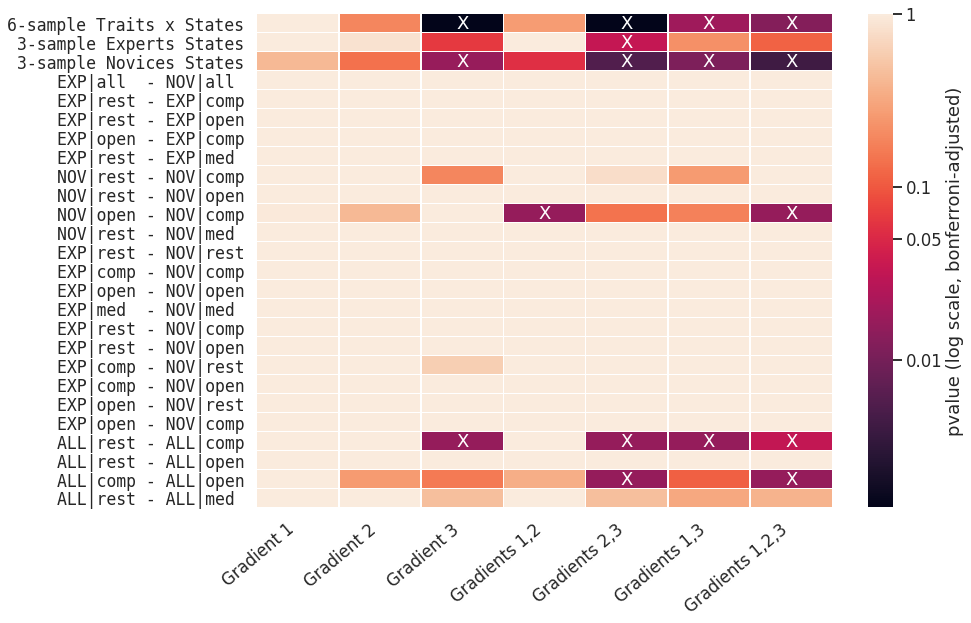

In [21]:
mask = pvalues.copy()
alpha = 0.05
mask[:] = np.select([
    mask < alpha, mask >= alpha],
    ['X', ''],
    default=mask
)

f, ax = plt.subplots(1, figsize=(14,9))
ax = sns.heatmap(
    pvalues.transform('log10'),
    ax=ax,
    annot=mask,#sig_labels,#True,
    #cmap='coolwarm_r',
    #center=np.log10(0.05),
    fmt='',
    square=False,
    linewidths=.5,
    #vmin=0,
    #vmax=0.1,
    #norm=log_norm,
    cbar_kws={"ticks": np.log10([0.01, 0.05,0.1,1])},
    #yticklabels = fmt_index
)
ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
ax.collections[0].colorbar.set_ticklabels([0.01, 0.05,0.1,1])

# x labels
loc, xlabels = plt.xticks()
ax.set_xticklabels(xlabels, rotation=40, ha='right')

# y labels
# plt.draw()  # this is needed because get_window_extent needs a renderer to work
# yax = ax.get_yaxis()
# # find the maximum width of the label on the major ticks
# pad = max(T.label.get_window_extent().width for T in yax.majorTicks)

# yax.set_tick_params(pad=pad)
# plt.draw()

ax.set_yticklabels(ax.get_yticklabels(), ha='right', fontdict={'family' : 'monospace'})

plt.tight_layout()
plt.savefig(heatmap_dir / f'pvalues_dcorr_gcca_perm_10000.pdf', bbox_inches='tight')
plt.show()

### Holm-Bonferroni

In [65]:
pvalues = pd.read_csv(
    Path('../data/') / '2sample_tests' / 'DCORR_restricted_perm_pvalues_100000_min_rank-ZG3.csv',
    index_col=0
)
# pvalues = pvalues.drop([
#     'Experts Resting vs. Novices Meditating', 'Experts Meditating vs. Novices Resting'
# ])

pvalues.columns = [name_dict[v] for v in pvalues.columns]
fmt_index = ["{:^3s}|{:<3s} - {:^3s}|{:<3s}".format(*[label_dict[vv] for vv in name_dict[v]]) for v in pvalues.index]
pvalues.index = fmt_index
# pvalues = pvalues * np.product(pvalues.shape)
# pvalues[pvalues > 1] = 1

In [66]:
d = pvalues.to_numpy()
temp = d.reshape(-1).argsort()

In [67]:
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(temp))

In [68]:
cutoffs = 0.05 / (len(temp) - ranks + 1)

In [69]:
(d.reshape(-1)[temp] - cutoffs[temp])[np.argsort(temp)] < 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

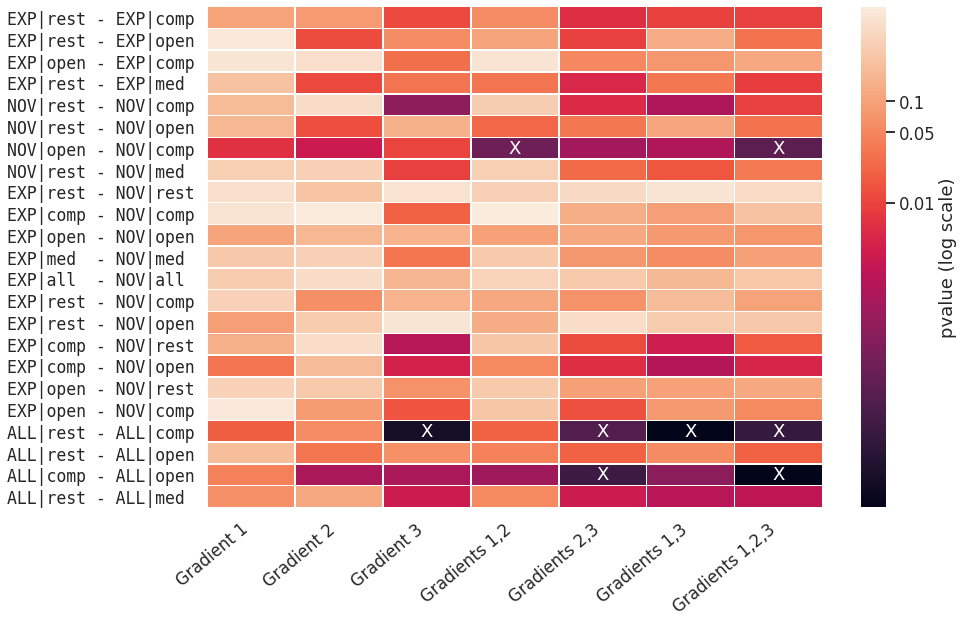

In [70]:
mask = pvalues.copy()
sig_mask = (d.reshape(-1)[temp] - cutoffs[temp])[np.argsort(temp)].reshape(d.shape)
alpha = 0.05
mask[:] = np.select([
    #sig_mask < 0, sig_mask >= 0],
    mask < alpha, mask >= alpha],
    ['X', ''],
    default=mask
)

f, ax = plt.subplots(1, figsize=(14,9))
ax = sns.heatmap(
    pvalues.transform('log10'),
    ax=ax,
    annot=mask,#sig_labels,#True,
    #cmap='coolwarm_r',
    #center=np.log10(0.05),
    fmt='',
    square=False,
    linewidths=.5,
    #vmin=0,
    #vmax=0.1,
    #norm=log_norm,
    cbar_kws={"ticks": np.log10([0.01, 0.05,0.1,1])},
    #yticklabels = fmt_index
)
ax.collections[0].colorbar.set_label("pvalue (log scale)")
ax.collections[0].colorbar.set_ticklabels([0.01, 0.05,0.1,1])

# x labels
loc, xlabels = plt.xticks()
ax.set_xticklabels(xlabels, rotation=40, ha='right')

# y labels
# plt.draw()  # this is needed because get_window_extent needs a renderer to work
# yax = ax.get_yaxis()
# # find the maximum width of the label on the major ticks
# pad = max(T.label.get_window_extent().width for T in yax.majorTicks)

# yax.set_tick_params(pad=pad)
# plt.draw()

ax.set_yticklabels(ax.get_yticklabels(), ha='right', fontdict={'family' : 'monospace'})

plt.tight_layout()
#plt.savefig(heatmap_dir / f'pvalues_dcorr_perm_100000.pdf', bbox_inches='tight')
plt.show()